In [51]:
import os
import pydiffvg
from PIL import Image
import matplotlib.pyplot as plt
import torch
import numpy as np
from scipy.ndimage import gaussian_filter
from skimage.color import rgb2gray
from skimage.filters import threshold_otsu
from skimage.transform import warp
from skimage import transform as tf
import imageio 
import matplotlib.font_manager as font_manager
import skimage
import skimage.io
from torchvision import transforms
import os, sys
import PIL
p = os.path.abspath('..')
sys.path.insert(1, p)
import sketch_utils as utils
from U2Net_.model import U2NET
from scipy import ndimage

In [99]:
def get_mask_u2net(tensor_im, device, use_gpu=True):
    data_transforms = transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(
            0.26862954, 0.26130258, 0.27577711)),
    ])

    input_im_trans = data_transforms(tensor_im).to(device)

    model_dir = os.path.join("/home/vinker/dev/backgroundCLIPasso/CLIPasso/U2Net_/saved_models/u2net.pth")
    net = U2NET(3, 1)
    if torch.cuda.is_available() and use_gpu:
        net.load_state_dict(torch.load(model_dir, map_location=torch.device("cuda:2")))
        net.to(device)
    else:
        net.load_state_dict(torch.load(model_dir, map_location='cpu'))
    net.eval()
    with torch.no_grad():
        d1, d2, d3, d4, d5, d6, d7 = net(input_im_trans.detach())
    pred = d1[:, 0, :, :]
    pred = (pred - pred.min()) / (pred.max() - pred.min())
    predict = pred
    predict[predict < 0.5] = 0
    predict[predict >= 0.5] = 1
    
    # print(predict[0].shape, ndimage.generate_binary_structure(5, 5).shape)
    predict = 1 - torch.tensor(ndimage.binary_dilation(predict[0].cpu().numpy(), structure=np.ones((11,11))).astype(np.int)).unsqueeze(0)
    mask = torch.cat([predict, predict, predict], axis=0).permute(1, 2, 0)
    mask = mask.cpu().numpy()
    
    print(mask.max(), mask.dtype)
    # predict_np = predict.clone().cpu().data.numpy()
    im = Image.fromarray((mask[:, :, 0]*255).astype(np.uint8)).convert('RGB')
    # im.save(f"{args.output_dir}/mask.png")

    im_np = tensor_im[0].permute(1,2,0).cpu().numpy()
    im_np = im_np / im_np.max()
    im_np = mask * im_np
    im_np[mask == 0] = 1
    im_final = (im_np / im_np.max() * 255).astype(np.uint8)
    im_final = Image.fromarray(im_final)

    return im_final, predict


def get_target(target_, device, image_scale=224):
    target = Image.open(target_)
    print(target.size)
    if target.mode == "RGBA":
        # Create a white rgba background
        new_image = Image.new("RGBA", target.size, "WHITE")
        # Paste the image on the background.
        new_image.paste(target, (0, 0), target)
        target = new_image
    target = target.convert("RGB").resize((224,224))
    
    
    # if args.mask_object:
    # target = masked_im
    # if args.fix_scale:
    #     target = utils.fix_image_scale(target)

    transforms_ = []
    if target.size[0] != target.size[1]:
        transforms_.append(transforms.Resize(
            (image_scale, image_scale), interpolation=PIL.Image.BICUBIC))
    else:
        transforms_.append(transforms.Resize(
            image_scale, interpolation=PIL.Image.BICUBIC))
        transforms_.append(transforms.CenterCrop(image_scale))
    transforms_.append(transforms.ToTensor())
    data_transforms = transforms.Compose(transforms_)
    target_ = data_transforms(target).unsqueeze(0).to(device)
    print(target_.shape)
    masked_im, mask = get_mask_u2net(target_, device, use_gpu=True)
    return target_, mask

(500, 500)
torch.Size([1, 3, 224, 224])
1 int64


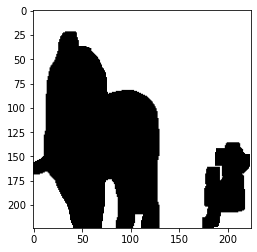

In [102]:
file_name = "semi-complex"
input_image_path=f"/home/vinker/dev/background_project/notebooks/complex_level_scenes/{file_name}.jpeg"
device = torch.device("cuda:2" if (
        torch.cuda.is_available() and torch.cuda.device_count() > 0) else "cpu")
inputs, mask = get_target(input_image_path, device)
plt.imshow(mask[0], cmap="gray")
plt.show()

In [87]:
%cd ..
%ls

/home/vinker/dev/backgroundCLIPasso/CLIPasso
CLIP_/                     config.py               repo_images/
CLIPasso-local-demo.ipynb  display_results.py      requirements.txt
CLIPasso.ipynb             models/                 run_object_sketching.py
README.md                  notebooks/              sketch_utils.py
U2Net_/                    output_sketches/        target_images/
__pycache__/               painterly_rendering.py
cog.yaml                   predict.py


In [90]:
!CUDA_VISIBLE_DEVICES=2 python run_object_sketching.py --target_file "camel.png" --num_sketches 1 --num_iter 11

Figure(640x480)
100%|███████████████████████████████████████████| 11/11 [00:02<00:00,  4.34it/s]
